<a href="https://colab.research.google.com/github/Blackan06/Build-a-Customer-Churn-Prediction-Model-Using-Decision-Trees/blob/main/Build_a_Customer_Churn_Prediction_Model_Using_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE

#Load the Dataset Customer Churn

In [5]:
file_path = '/content/Customer_Data.csv'
data = pd.read_csv(file_path)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6418 entries, 0 to 6417
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  6418 non-null   object 
 1   Gender                       6418 non-null   object 
 2   Age                          6418 non-null   int64  
 3   Married                      6418 non-null   object 
 4   State                        6418 non-null   object 
 5   Number_of_Referrals          6418 non-null   int64  
 6   Tenure_in_Months             6418 non-null   int64  
 7   Value_Deal                   2870 non-null   object 
 8   Phone_Service                6418 non-null   object 
 9   Multiple_Lines               5796 non-null   object 
 10  Internet_Service             6418 non-null   object 
 11  Internet_Type                5028 non-null   object 
 12  Online_Security              5028 non-null   object 
 13  Online_Backup     

#Handle missing values


In [6]:
data_cleaned = data.drop(columns=['Churn_Reason', 'Churn_Category'])

numerical_columns = data_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns.tolist()

for col in categorical_columns:
    if data_cleaned[col].isnull().sum() > 0:
        data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)

for col in numerical_columns:
    if data_cleaned[col].isnull().sum() > 0:
        data_cleaned[col].fillna(data_cleaned[col].median(), inplace=True)


<ipython-input-6-dd6ce2540747>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_cleaned[col].fillna(data_cleaned[col].mode()[0], inplace=True)


#One-Hot Encoding

In [7]:
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)


#Normalizing Numerical Data

In [8]:
scaler = StandardScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

#Splitting Data into Train, Validation, and Test Sets


In [9]:
# Split into train and test sets (80% train, 20% test)
X = data_encoded.drop(columns=['Customer_Status_Stayed'])
y = data_encoded['Customer_Status_Stayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Handling Imbalanced Data using SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#Building the Random Forest Classifier Model with Hyperparameter Tuning

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'max_features': ['auto', 'sqrt'],
    'class_weight': ['balanced', None]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_res, y_train_res)

# Best model after hyperparameter tuning
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
49 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

#Evaluating the Model on Validation Set

In [22]:
y_val_pred = best_rf_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)
print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_val:.2%}")  # Display accuracy as a percentage
print(f"Precision: {precision_val:.2f}")
print(f"Recall: {recall_val:.2f}")
print(f"F1 Score: {f1_val:.2f}")


Validation Set Metrics:
Accuracy: 84.81%
Precision: 0.86
Recall: 0.92
F1 Score: 0.89


# Evaluating the Model on Test Set

In [25]:
y_test_pred = best_rf_model.predict(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred)

# Displaying the evaluation metrics for both validation and test sets
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_test:.2%}")  # Display accuracy as a percentage
print(f"Precision: {precision_test:.2f}")
print(f"Recall: {recall_test:.2f}")
print(f"F1 Score: {f1_test:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")


Test Set Metrics:
Accuracy: 85.98%
Precision: 0.87
Recall: 0.93
F1 Score: 0.90
ROC AUC Score: 0.82


In [24]:
print("\nClassification Report for Test Set:\n", classification_report(y_test, y_test_pred))


Classification Report for Test Set:
               precision    recall  f1-score   support

       False       0.83      0.70      0.76       408
        True       0.87      0.93      0.90       876

    accuracy                           0.86      1284
   macro avg       0.85      0.82      0.83      1284
weighted avg       0.86      0.86      0.86      1284



#Plotting the Confusion Matrix for the Test Set

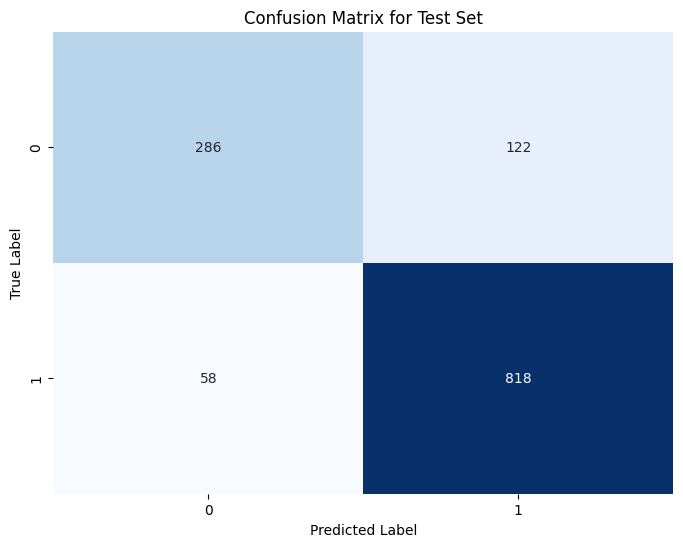

In [19]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plotting Feature Importances

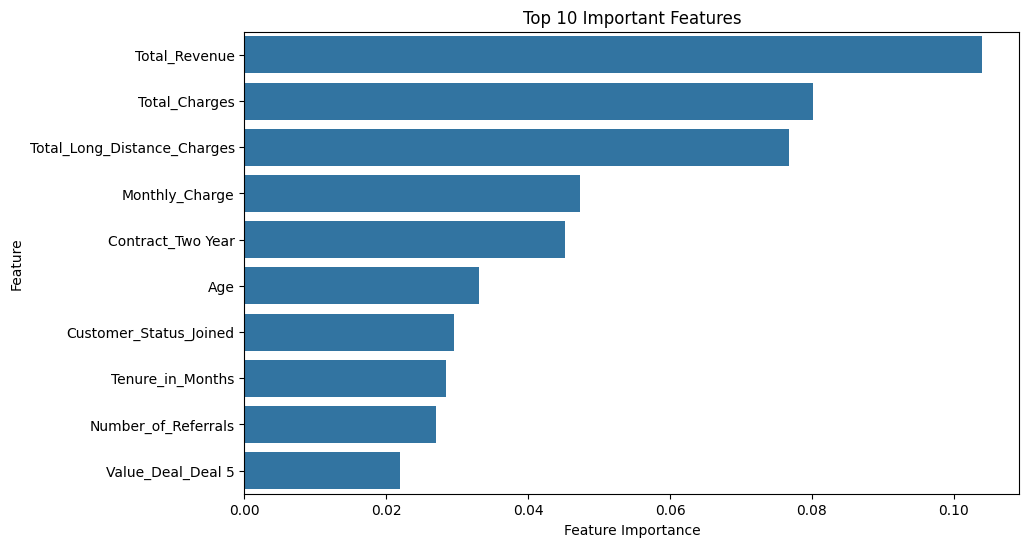

In [20]:
feature_importances = best_rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Top 10 Important Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

#Plotting ROC Curve

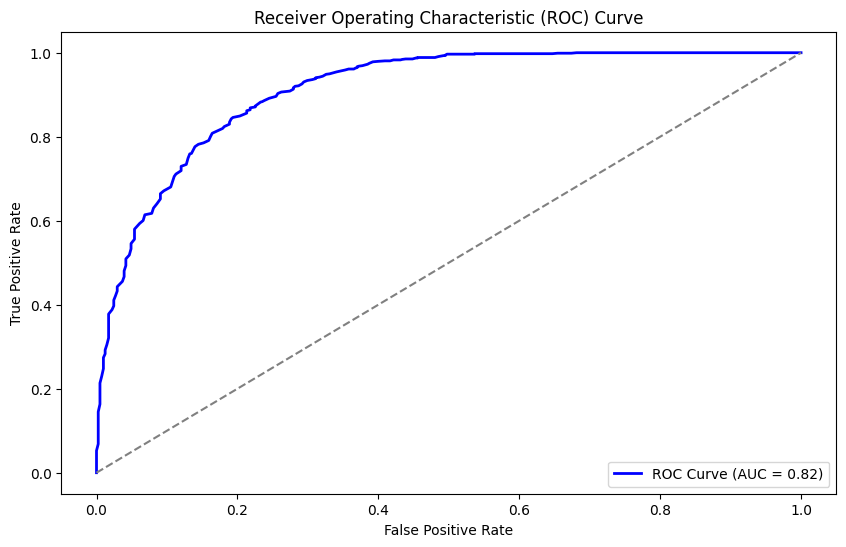

In [21]:
y_test_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#Exporting Test Predictions to CSV

In [26]:

# Create a DataFrame with actual and predicted labels
output_df = X_test.copy()
output_df['Actual_Customer_Status'] = y_test
output_df['Predicted_Customer_Status'] = y_test_pred

# Save the DataFrame to a CSV file
output_file_path = '/content/Test_Set_Predictions.csv'
output_df.to_csv(output_file_path, index=False)
print(f"Test set predictions saved to {output_file_path}")


Test set predictions saved to /content/Test_Set_Predictions.csv
